## Import Necessary Libraries

In [234]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import string 
import json

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
plt.style.use('seaborn')

[nltk_data] Downloading package stopwords to C:\Users\Rafic
[nltk_data]     Srouji\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rafic
[nltk_data]     Srouji\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Rafic
[nltk_data]     Srouji\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Defining Functions

In [235]:
songs=[]
artists=[]
year=[]
list_for_url = []
lyrics=[]
def get_top_songs():
    
    for i in range(2006,2021):
        result=requests.get(f"https://www.billboard.com/charts/year-end/{i}/hot-100-songs/")
        src = result.content
        soup=BeautifulSoup(src,'lxml')
        links = soup.find_all("h3")
        links_years = soup.find_all("h4")
        links_artists = soup.find_all("span",{"class":["c-label a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block u-font-size-20@tablet","c-label a-font-primary-s lrv-u-font-size-14@mobile-max u-line-height-normal@mobile-max u-letter-spacing-0021 lrv-u-display-block"]})
        for j in range(10):
            songs.append(links[j].text.strip())
            artists.append(links_artists[j].text.strip())
            year.append(links_years[0].text.strip())

def clean_for_bs4(df1):
    for i in range(len(df1)):
        x=re.match('.*Featuring.*$',df1['artist'][i])
        n=re.match('.*Duet With.*$',df1['artist'][i])
        y = re.match('.*&.*$',df1['artist'][i])
        z = re.match(r'.*\(.*\)$',df1['title'][i])
        w = re.match(r".*'.*",df1['title'][i])
        m = re.match(r".*'.*|.*'$|",df1['artist'][i])
        t = re.match(r".*,.*",df1['artist'][i])
        p = re.match(r".*\$.*",df1['artist'][i])
        a = re.match(r".*\!$",df1['artist'][i])
        b = re.match(r".*\..*|\.$",df1['artist'][i])
        c = re.match(r".*\!.*",df1['artist'][i])
        d = re.match(r"The Black.*",df1['artist'][i])
        e = re.match(r".*Florida.*",df1['artist'][i])
        f = re.match(r".*\..*|\.$",df1['title'][i])
        g = re.match(r".*Fifty Shades.*|.*Spider-man.*",df1['title'][i])
        h = re.match(r".*\!$",df1['title'][i])
        k = re.match(r"\s.*",df1['artist'][i])
        l = re.match(r".*,.*",df1['title'][i])
        if x:
            result = re.sub(' Featuring.*$','',df1['artist'][i])
            df1['artist'][i] = result
        if y:
            result = re.sub('&','and',df1['artist'][i])
            df1['artist'][i] = result
        if z:
            result = re.sub(r'[\([{})\]]','',df1['title'][i])
            df1['title'][i] = result
        if w:
            result = re.sub(r"'",'',df1['title'][i])
            df1['title'][i]=result
        if t:
            result = re.sub(r",",'',df1['artist'][i])
            df1['artist'][i]=result
        if m:
            result = re.sub(r"'",'',df1['artist'][i])
            df1['artist'][i]=result
        if n:
            result = re.sub(' Duet.*$','',df1['artist'][i])
            df1['artist'][i]=result
        if p:
            result=re.sub(r"\$",'s',df1['artist'][i])
            df1['artist'][i]=result
        if a:
            result=re.sub("\!",'',df1['artist'][i])
            df1['artist'][i]=result
        if b:
            result=re.sub(r"\.",'',df1['artist'][i])
            df1['artist'][i]=result
        if c:
            result=re.sub(r"\!"," ",df1['artist'][i])
            df1['artist'][i]=result
        if d:
            result=re.sub("The",'',df1['artist'][i])
            df1['artist'][i]=result
        if e:
            result=re.sub(" and Florida.*",'',df1['artist'][i])
            df1['artist'][i]=result
        if f:
            result = re.sub("\.",'',df1['title'][i])
            df1['title'][i]=result
        if g:
            result = re.sub(r" Spider-Man.*| Fifty Shades.*",'',df['title'][i])
            df1['title'][i] = result
        if h:
            result = re.sub("\!",'',df1['title'][i])
            df1['title'][i]=result
        if k:
            result = re.sub(r"^\s",'',df1['artist'][i])
            df1['artist'][i]=result
        if l:
            result = re.sub(r",",'',df1['title'][i])
            df1['title'][i]=result

def normalize(df1):
    for i in range(len(df1)):
        s = df1['artist'][i].lower() + " " + df1['title'][i].lower()
        d = re.sub(' ','-',s)
        list_for_url.append(d)


def get_lyrics():
    for i in range(len(list_for_url)):
        place=' '
        url = f'https://genius.com/{list_for_url[i]}-lyrics'
        soup = BeautifulSoup(requests.get(url).content, 'lxml')

        for tag in soup.select('div[class^="Lyrics__Container"], .song_body-lyrics p'):
            t = tag.get_text(strip=True,separator='\n')
            if t:
                place=place + t
        lyrics.append(place)
        
def unique(list1):
   # intilize a null list
    unique_list = []
   # traverse for all elements
    for x in list1:
         # check if exists in unique_list or not
            if x not in unique_list:
                unique_list.append(x)
    return unique_list

def clean_lyrics(df,column):
    """
    This function cleans the words without importance and fix the format of the dataframe's column lyrics
    
    parameters:
    
    df = dataframe
    column = name of the column to clean
    """
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"verse |\d+|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
    df[column] = df[column].str.replace(r"\n|:|\.|\(|\)","")
    df[column] = df[column].str.replace(r"\\","")
    df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df[column] = df[column].str.strip()
    
def lyrics_to_words(document):
    """
    This function splits the text of lyrics to  single words, removing stopwords and doing the lemmatization to each word
    parameters:
    document: text to split to single words
    """
    stop_words = set(stopwords.words('english','spanish'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

def plot_wordcloud(df,row,col):
    wc = WordCloud(background_color="white",colormap="Dark2",max_font_size=100,random_state=15)
    fig = plt.figure(figsize=(20,10))
     
    for index, value in enumerate(df.columns[1:]):
        top_dict = dict(zip(df['words'].tolist(),df[value].tolist()))
        wc.generate_from_frequencies(top_dict)
        plt.subplot(row,col,index+1)
        plt.imshow(wc,interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{value}",fontsize=15)

In [236]:
f = open('artist_genres.json')

In [237]:
music = json.load(f)

In [238]:
len(music)

105

### Search for top songs from 2006 to 2020 from billboard

In [239]:
get_top_songs()
#convert the lists to dataframe
df = pd.DataFrame({'artist':artists,'title':songs,'year':year})

In [189]:
artists

['Daniel Powter',
 'Sean Paul',
 'Nelly Furtado Featuring Timbaland',
 'James Blunt',
 'Shakira Featuring Wyclef Jean',
 'Natasha Bedingfield',
 'Gnarls Barkley',
 'Chamillionaire Featuring Krayzie Bone',
 'Justin Timberlake',
 'Beyonce Featuring Slim Thug',
 'Beyonce',
 'Rihanna Featuring Jay-Z',
 'Gwen Stefani Featuring Akon',
 'Fergie',
 'T-Pain Featuring Yung Joc',
 'Carrie Underwood',
 "Plain White T's",
 'Akon Featuring Snoop Dogg',
 'Nelly Furtado',
 'Fergie Featuring Ludacris',
 'Flo Rida Featuring T-Pain',
 'Leona Lewis',
 'Alicia Keys',
 'Lil Wayne Featuring Static Major',
 'Timbaland Featuring OneRepublic',
 'Jordin Sparks Duet With Chris Brown',
 'Sara Bareilles',
 'Usher Featuring Young Jeezy',
 'Chris Brown',
 'Chris Brown',
 'The Black Eyed Peas',
 'Lady Gaga',
 "Lady Gaga Featuring Colby O'Donis",
 'The Black Eyed Peas',
 'Taylor Swift',
 'Flo Rida',
 'Jason Mraz',
 'Beyonce',
 'Kanye West',
 'The All-American Rejects',
 'Ke$ha',
 'Lady Antebellum',
 'Train',
 'Katy Per

In [240]:
df

,artist,title,year
0,Daniel Powter,Bad Day,2006
1,Sean Paul,Temperature,2006
2,Nelly Furtado Featuring Timbaland,Promiscuous,2006
3,James Blunt,You're Beautiful,2006
4,Shakira Featuring Wyclef Jean,Hips Don't Lie,2006
...,...,...,...
145,Harry Styles,Adore You,2020
146,Future Featuring Drake,Life Is Good,2020
147,Maroon 5,Memories,2020
148,Maren Morris,The Bones,2020


In [241]:
df.to_json("top_songs.json",orient='split',indent=4)

In [242]:
df.to_csv("top_songs.csv")

## Cleaning the Data

In [243]:
clean_for_bs4(df)
for x in range(len(df)):
    y = re.search(r".*Spider-Man.*|.*Fifty Shades.*",df['title'][x])
    if y:
        d = re.sub(r" Spider-Man.*| Fifty Shades.*",'',df['title'][x])
        df['title'][x]=d

In [244]:
df['title'][131]

'Sunflower'

In [245]:

normalize(df)
for i in range(len(list_for_url)):
    if re.match("^-.*",list_for_url[i]):
        x = re.sub("^-","",list_for_url[i])
        list_for_url[i]=x

In [246]:
list_for_url[131]

'post-malone-and-swae-lee-sunflower'

## Retrieve Lyrics from Genius.com

In [248]:
get_lyrics()

In [249]:
lyrics[30]

" [Album Intro]\nWelcome\nWelcome to The E.N.D\nDo not panic, there is nothing to fear\nEverything around you is changing\nNothing stays the same\nThis version of myself is not permanent\nTomorrow, I will be different\nThe energy never dies\nEnergy cannot be destroyed, or created\nIt always is, and it always will be\nThis is the end, and the beginning..\nForever infinite\nWelcome\n[Intro: will.i.am]\nGotta get that\nGotta get that\nGotta get that\nGotta get that, that, that, that, that\n[Chorus: will.i.am]\nBoom boom boom\nGotta get that boom boom boom\nGotta get that boom boom boom\nGotta get that boom boom boom\nGotta get that boom boom boom\nThat boom boom boom\nThat boom boom boom\nBoom boom boom[Verse 1: will.i.am]\nYo, I got that hit to beat the block\nYou can get that bass on below\nI got that rock 'n' roll, that future flow\nThat digital spit, next level visual shit\nI got that boom boom boom\nHow the beat bang? Boom boom boom\n[Pre-Chorus: Fergie]\nI like that boom boom pow\nT

In [250]:
df['lyrics'] = None
for i in range(len(df)):
    df['lyrics'][i]=lyrics[i]


In [251]:
df.iloc[120,3]

' [Intro]\nAnd they wishin\' and wishin\' and wishin\' and wishin\'\nThey wishin\' on me, yeah\n[Verse 1]\nI been movin\' calm, don\'t start no trouble with me\nTryna keep it peaceful is a struggle for me\nDon\'t pull up at 6 AM to cuddle with me\nYou know how I like it when you lovin\' on me\nI don\'t wanna die for them to miss me\nYes, I see the things that they wishin\' on me\nHope I got some brothers that outlive me\nThey gon\' tell the story, shit was different with me\n[Chorus]\nGod\'s plan, God\'s plan\nI hold back, sometimes I won\'t, yeah\nI feel good, sometimes I don\'t (Ayy, don\'t)\nI finessed down Weston Road (Ayy, \'nessed)\nMight go down a G.O.D. (Yeah, wait)\nI go hard on Southside G (Yeah, wait)\nI make sure that north-side eat\n[Post-Chorus]\nAnd still, bad things\nIt\'s a lot of bad things\nThat they wishin\' and wishin\' and wishin\' and wishin\'\nThey wishin\' on me\nBad things\nIt\'s a lot of bad things\nThat they wishin\' and wishin\' and wishin\' and wishin\'\nT

In [252]:
df.to_csv("top_songs_lyrics.csv")

### Clean Lyrics

In [253]:
clean_lyrics(df,'lyrics')

In [254]:
df.iloc[149,3]

"i'm going under, and this time, i fear there's no one to save methis all or nothing really got a way of driving me crazyi need somebody to hear,  somebody to knowsomebody to have, somebody to holdit's easy to say, but it's never the samei guess i kinda liked the way you numbed all the painnow, the day bleeds into nightfalland you're not here to get me through it alli let my guard down and then you pulled the rugi was getting kinda used to being someone you lovedi'm going under, and this time, i fear there's no one to turn tothis all or nothing way of loving got me sleeping without younow, i need somebody to know, somebody to hearsomebody to have, just to know how it feelsit's easy to say, but it's never the samei guess i kinda like the way you help me escapenow, the day bleeds into nightfalland you're not here to get me through it alli let my guard down and then you pulled the rugi was getting kinda used to being someone you lovedand i tend to close my eyes when it hurts sometimesi fa

In [265]:
df['genre'] = None
for i in range(len(df)):
    for j in music.keys():
        if df['artist'][i] == j:
            df['genre'][i] = music[j]
        else:
            pass

In [266]:
df.head()

,artist,title,year,lyrics,genre
0,Daniel Powter,Bad Day,2006,where is the moment we needed the most?you kic...,pop
1,Sean Paul,Temperature,2006,"the gyal dem schillaci, sean a paulso me give ...",pop
2,Nelly Furtado,Promiscuous,2006,nelly furtado &timbalandam i throwin' you off?...,latin
3,James Blunt,Youre Beautiful,2006,"my life is brilliantmy life is brilliant, my l...",pop
4,Shakira,Hips Dont Lie,2006,wyclef jeanladies up in here tonightno fightin...,pop


In [267]:
df['genre'][4] = 'pop'
df['genre'][9] = 'pop'
df['genre'][10] = 'pop'
df['genre'][14] = 'pop'
df['genre'][15]='country'
df['genre'][16]='pop'
df['genre'][17]='pop'
df['genre'][23]='hip hop'
df['genre'][24]='pop'
df['genre'][37] = 'pop'
df['genre'][41] = 'country'
df['genre'][42] = 'pop'
df['genre'][45] = 'hip hop'
df['genre'][62] = 'pop'
df['genre'][70] = 'rap'
df['genre'][74] = 'rap'
df['genre'][76] = 'pop'
df['genre'][78] = 'country'
df['genre'][80] = 'pop'
df['genre'][86] = 'pop'
df['genre'][88] = 'pop'
df['genre'][92] = 'hip hop'
df['genre'][97] = 'hip hop'
df['genre'][100] = 'pop'
df['genre'][101] = 'pop'
df['genre'][104] = 'rock'
df['genre'][111] = 'latin'
df['genre'][113] = 'hip hop'
df['genre'][114] = 'pop'
df['genre'][115] = 'hip hop'
df['genre'][117] = 'country'
df['genre'][126] = 'pop'
#df['genre'][127] = 'electro house'
#df['genre'][131] = 'rap'
#df['genre'][132] = 'pop'
#df['genre'][135] = 'electro house'
#df['genre'][136] = 'pop'
#df['genre'][137] = 'pop'
#df['genre'][138] = 'rap'
#df['genre'][139] = 'pop'
#df['genre'][146] = 'hip hop'
#df['genre'][148] = 'country'


In [280]:
df['genre'] = None
for i in range(len(df)):
    for m,n in music.items():
        if df['artist'][i] == m:
            df['genre'][i] = n
        else:
            pass

## Extracting Unique Words

In [281]:
#Stores unique words of each lyrics song into a new column called words
#list used to store the words
words = []
#iterate trought each lyric and split unique words appending the result into the words list
df = df.reset_index(drop=True)
for word in df['lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
#create the new column with the information of words lists
df['words'] = words
df.head()

,artist,title,year,lyrics,genre,words
0,Daniel Powter,Bad Day,2006,where is the moment we needed the most?you kic...,pop,"[moment, needed, mostyou, kick, leaf, magic, l..."
1,Sean Paul,Temperature,2006,"the gyal dem schillaci, sean a paulso me give ...",pop,"[gyal, dem, schillaci, sean, paulso, give, to,..."
2,Nelly Furtado,Promiscuous,2006,nelly furtado &timbalandam i throwin' you off?...,latin,"[nelly, furtado, timbalandam, throwin, offnope..."
3,James Blunt,Youre Beautiful,2006,"my life is brilliantmy life is brilliant, my l...",pop,"[life, brilliantmy, brilliant, love, purei, sa..."
4,Shakira,Hips Dont Lie,2006,wyclef jeanladies up in here tonightno fightin...,pop,"[wyclef, jeanladies, tonightno, fightingwe, go..."


In [282]:
music_dic = dict()
for i in range(len(df)):
    music_dic[df['artist'][i]] = df['genre'][i]

In [283]:
music_dic

{'Daniel Powter': 'pop',
 'Sean Paul': 'pop',
 'Nelly Furtado': 'latin',
 'James Blunt': 'pop',
 'Shakira': 'pop',
 'Natasha Bedingfield': 'pop',
 'Gnarls Barkley': 'hip hop',
 'Chamillionaire': 'rap',
 'Justin Timberlake': 'pop',
 'Beyonce': 'pop',
 'Rihanna': 'pop',
 'Gwen Stefani': 'pop',
 'Fergie': 'pop',
 'T-Pain': 'pop',
 'Carrie Underwood': 'country',
 'Plain White Ts': 'pop',
 'Akon': 'pop',
 'Flo Rida': 'pop',
 'Leona Lewis': 'r&b',
 'Alicia Keys': 'pop',
 'Lil Wayne': 'hip hop',
 'Timbaland': 'pop',
 'Jordin Sparks': 'pop',
 'Sara Bareilles': 'pop',
 'Usher': 'hip hop',
 'Chris Brown': 'pop',
 ' Black Eyed Peas': None,
 'Lady Gaga': 'pop',
 'Taylor Swift': 'pop',
 'Jason Mraz': 'pop',
 'Kanye West': 'rap',
 'The All-American Rejects': 'rock',
 'Kesha': 'pop',
 'Lady Antebellum': 'country',
 'Train': 'pop',
 'Katy Perry': 'pop',
 'BoB': 'hip hop',
 'Eminem': 'hip hop',
 'Taio Cruz': 'pop',
 'Adele': 'r&b',
 'LMFAO': 'pop',
 'Pitbull': 'pop',
 'Bruno Mars': 'pop',
 'Nicki Minaj

In [284]:
df[df['genre']=='']

,artist,title,year,lyrics,genre,words


In [285]:
df.tail(25)

,artist,title,year,lyrics,genre,words
125,Post Malone,Psycho,2018,"post malonedamn, my ap goin' psycho, lil' mama...",rap,"[post, malonedamn, ap, goin, psycho, lil, mama..."
126,Cardi B Bad Bunny and J Balvin,I Like It,2018,"yeah, baby,i like it like thatyou gotta believ...",pop,"[yeah, babyi, like, thatyou, gotta, believe, t..."
127,Zedd Maren Morris and Grey,The Middle,2018,"maren morristake a seatright over there, sat o...",electro house,"[maren, morristake, seatright, there, sat, sta..."
128,Drake,In My Feelings,2018,"draketrap, trapmoneybennythis shit got me in m...",hip hop,"[draketrap, trapmoneybennythis, shit, got, fee..."
129,Maroon 5,Girls Like You,2018,"spent hours, i need more hours with youyou sp...",pop,"[spent, hour, need, youyou, weekend, getting, ..."
130,Lil Nas X,Old Town Road,2019,"yeah, i'm gonna take my horse to the old town ...",hip hop,"[yeah, im, gonna, take, horse, old, town, road..."
131,Post Malone and Swae Lee,Sunflower,2019,"swae leeayy, ayy, ayy, ayy oohooh, ooh, ooh, o...",rap,"[swae, leeayy, ayy, oohooh, ooh, oohayy, ayyoo..."
132,Halsey,Without Me,2019,found you when your heart was brokei filled yo...,pop,"[found, heart, brokei, filled, cup, overflowed..."
133,Billie Eilish,Bad Guy,2019,"white shirt now red, my bloody nosesleepin', y...",pop,"[white, shirt, red, bloody, nosesleepin, tippy..."
134,Post Malone,Wow,2019,"said she tired of little money, need a big boy...",rap,"[said, tired, little, money, need, big, boypul..."


## Sentiment Analysis

In [286]:
sentiments = []
for i in range(len(df)):
    sentiment_objects = TextBlob(df['lyrics'][i])
    sentiments.append(sentiment_objects)


In [287]:
sentiment_values = [ly.sentiment.polarity for ly in sentiments]

In [288]:
df['polarity'] = None
for i in range(len(df)):
    df['polarity'][i] = round(sentiment_values[i],2)

In [289]:
df['polarity']=df['polarity'].astype(float)

In [290]:
#Create lists to store the different scores for each word
negative = []
neutral = []
positive = []
compound = []
#Initialize the model
sid = SentimentIntensityAnalyzer()
#Iterate for each row of lyrics and append the scores
for i in df.index:
    scores = sid.polarity_scores(df['lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])
#Create 4 columns to the main data frame  for each score
df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['compound'] = compound
df.head()

,artist,title,year,lyrics,genre,words,polarity,negative,neutral,positive,compound
0,Daniel Powter,Bad Day,2006,where is the moment we needed the most?you kic...,pop,"[moment, needed, mostyou, kick, leaf, magic, l...",-0.22,0.203,0.732,0.066,-0.9943
1,Sean Paul,Temperature,2006,"the gyal dem schillaci, sean a paulso me give ...",pop,"[gyal, dem, schillaci, sean, paulso, give, to,...",0.04,0.025,0.869,0.105,0.9937
2,Nelly Furtado,Promiscuous,2006,nelly furtado &timbalandam i throwin' you off?...,latin,"[nelly, furtado, timbalandam, throwin, offnope...",-0.12,0.052,0.851,0.097,0.9627
3,James Blunt,Youre Beautiful,2006,"my life is brilliantmy life is brilliant, my l...",pop,"[life, brilliantmy, brilliant, love, purei, sa...",0.57,0.000,0.769,0.231,0.9923
4,Shakira,Hips Dont Lie,2006,wyclef jeanladies up in here tonightno fightin...,pop,"[wyclef, jeanladies, tonightno, fightingwe, go...",-0.03,0.037,0.828,0.135,0.9958


In [291]:
df.to_csv("sentiment.csv")

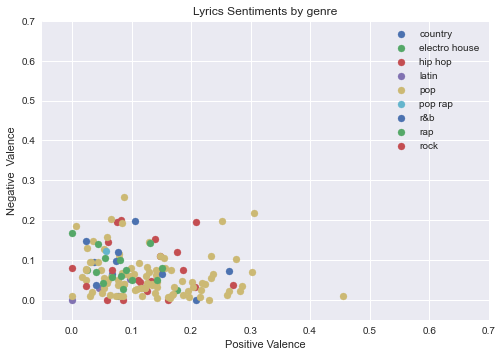

In [292]:
for name, group in df.groupby('genre'):
    plt.scatter(group['positive'],group['negative'],label=name)
    plt.legend(fontsize=10)
plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])
plt.title("Lyrics Sentiments by genre")
plt.xlabel('Positive Valence')
plt.ylabel('Negative  Valence')
plt.show()

In [293]:
score=df[['year','positive','neutral','negative']].groupby("year").mean()

In [294]:
score

,positive,neutral,negative
year,,,
2006,0.1125,0.8265,0.0610
2007,0.0990,0.8567,0.0444
2008,0.1218,0.8218,0.0562
2009,0.1413,0.8024,0.0565
2010,0.1333,0.8010,0.0659
2011,0.1389,0.8107,0.0502
2012,0.1269,0.8171,0.0559
2013,0.1097,0.8311,0.0591
2014,0.1400,0.7603,0.0999


In [295]:
score.to_csv("posr-neg.csv")

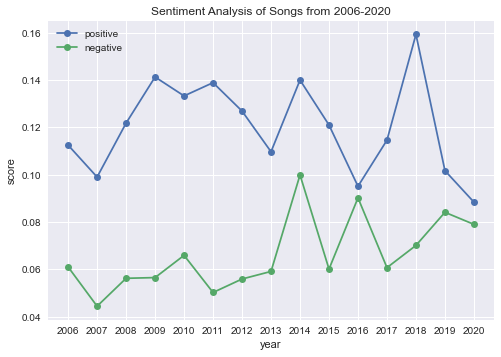

In [296]:
plt.plot(score.index,score['positive'],label='positive',marker='o')
plt.plot(score.index,score['negative'],label='negative',marker='o')
plt.xlabel('year')
plt.ylabel('score')
plt.title("Sentiment Analysis of Songs from 2006-2020")
plt.legend()

In [297]:
genre_df = df[['genre','positive','neutral','negative']].groupby("genre").mean()

In [298]:
def lyrics_to_words(document):
    """
    This function splits the text of lyrics to  single words, removing stopwords and doing the lemmatization to each word
    parameters:
    document: text to split to single words
    """
    stop_words = set(stopwords.words('english','spanish'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

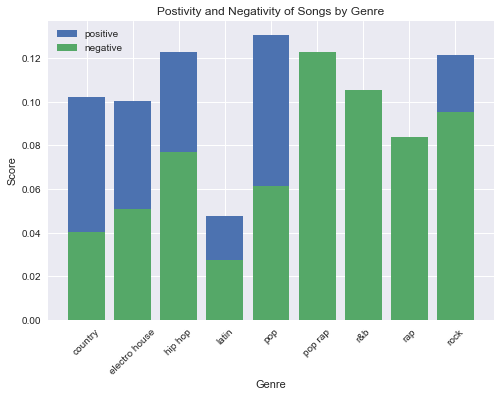

In [301]:
plt.bar(genre_df.index,genre_df['positive'],label='positive')
plt.bar(genre_df.index,genre_df['negative'],label='negative')
plt.title("Postivity and Negativity of Songs by Genre")
plt.legend()
plt.xlabel('Genre')
plt.ylabel('Score')
plt.xticks(rotation=45)

In [302]:

positive = 0
negative =0
neutral = 0
for i in range(len(df)):
    
    if df['polarity'][i]>0.00:
        positive += 1
    elif df['polarity'][i]<0.00:
        negative += 1
    else:
        neutral += 1
    
print("positive: " + str(positive))
print("negative: " + str(negative))
print("neutral: " + str(neutral))


positive: 108
negative: 36
neutral: 6


In [303]:
df[["genre","polarity"]].groupby("genre").mean()

,polarity
genre,
country,0.050000
electro house,0.095000
hip hop,0.094118
latin,-0.053333
pop,0.118298
pop rap,-0.100000
r&b,0.074286
rap,0.033571
rock,0.080000


In [304]:
df[['year','polarity']].groupby('year').mean()

,polarity
year,
2006,0.054
2007,0.138
2008,0.133
2009,0.092
2010,0.106
2011,0.139
2012,0.136
2013,0.088
2014,0.043


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   artist    150 non-null    object 
 1   title     150 non-null    object 
 2   year      150 non-null    object 
 3   lyrics    150 non-null    object 
 4   genre     147 non-null    object 
 5   words     150 non-null    object 
 6   polarity  150 non-null    float64
 7   negative  150 non-null    float64
 8   neutral   150 non-null    float64
 9   positive  150 non-null    float64
 10  compound  150 non-null    float64
dtypes: float64(5), object(6)
memory usage: 13.0+ KB


In [306]:
set_words = []
set_year = []
for i in range(len(df)):
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_year.append(df['year'].iloc[i])
        
words_df = pd.DataFrame({'words':set_words,'year':set_year})

#Defined  your own Stopwords in case the clean data function does not remove all of them
stop_words = ['verse','im','get','1000','58','60','80','youre','youve',
  'guitar','solo','instrumental','intro','pre',"3",'00','05','40','a','i','ill','oh','like','got','go','the','this','is','are','give',
             'know','make','re','yeah','than','let','aint','it','me']

# count the frequency of each word that aren't on the stop_words lists
cv = CountVectorizer(stop_words=stop_words)

text_cv = cv.fit_transform(words_df['words'].iloc[:])

data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names())
data_cv['year'] = words_df['year']

#created a dataframe that Sums the ocurrence frequency of each word and group the result by year

vect_words = data_cv.groupby('year').sum().T
vect_words = vect_words.reset_index(level=0).rename(columns ={'index':'words'})
vect_words = vect_words.rename_axis(columns='')
vect_words.to_csv('words.csv',index=False)

#change the order of columns to order from the oldest to actual year
vect_words = vect_words[['words','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020']]
vect_words


,words,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,aaghyou,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,aah,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,aahas,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,aahyoure,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,aaliyah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8636,zonerefraini,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8637,zoninand,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8638,zoomwhen,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8639,zoowap,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [307]:
vect_words['total']=vect_words['2006']+vect_words['2007']+vect_words['2008']+vect_words['2009']+vect_words['2010']+vect_words['2011']+vect_words['2012']+vect_words['2013']+vect_words['2014']+vect_words['2015']+vect_words['2016']+vect_words['2017']+vect_words['2018']+vect_words['2019']+vect_words['2020']

In [308]:
vect_words.sort_values(['total'],ascending=False).head(25)

,words,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,total
4221,love,2,4,7,6,6,4,4,3,6,7,3,2,4,3,5,66
6331,see,7,4,5,7,2,4,2,4,2,4,5,3,5,5,4,63
1125,cant,6,5,5,4,3,2,4,4,4,3,3,2,5,6,4,60
6248,say,4,4,8,2,1,3,2,4,3,2,3,3,5,7,7,58
4892,never,3,3,3,4,2,4,5,3,4,4,6,5,3,3,5,57
7996,way,7,2,6,6,6,1,4,2,2,3,4,4,1,5,3,56
444,baby,5,5,4,3,5,5,1,3,4,4,2,5,4,2,4,56
7948,wanna,6,5,4,5,4,4,1,4,4,5,3,2,2,2,3,54
469,back,4,2,2,2,5,4,3,4,4,1,4,3,5,4,6,53
7086,take,2,8,3,5,3,3,4,2,1,2,4,3,3,6,3,52


<Figure size 576x396 with 0 Axes>

ValueError: num must be 1 <= num <= 15, not 16

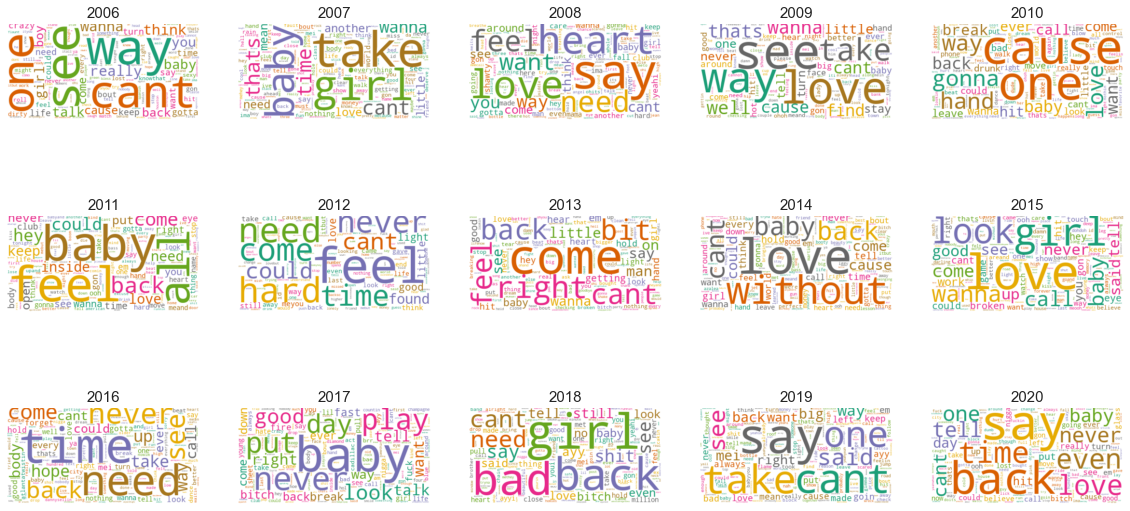

In [309]:

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
#Plot the word cloud
plot_wordcloud(vect_words,3,5)

In [310]:
set_words = []
set_genre = []
for i in range(len(df)):
    for word in df['words'].iloc[i]:
        set_words.append(word)
        set_genre.append(df['genre'].iloc[i])
        
words_gn_df = pd.DataFrame({'words':set_words,'genre':set_genre})

#Defined  your own Stopwords in case the clean data function does not remove all of them
stop_words = ['verse','im','get','1000','58','60','80','youre','youve',
  'guitar','solo','instrumental','intro','pre',"3",'00','05','40','a','i','ill','oh','like','got','go','the','this','is','are','give',
             'know','make','re','yeah','than','let','aint','it','cant']

# count the frequency of each word that aren't on the stop_words lists
cv = CountVectorizer(stop_words=stop_words)

text_cv = cv.fit_transform(words_gn_df['words'].iloc[:])

data_cv = pd.DataFrame(text_cv.toarray(),columns=cv.get_feature_names())
data_cv['genre'] = words_gn_df['genre']

#created a dataframe that Sums the ocurrence frequency of each word and group the result by year

gen_words = data_cv.groupby('genre').sum().T
gen_words = gen_words.reset_index(level=0).rename(columns ={'index':'words'})
gen_words = gen_words.rename_axis(columns='')
gen_words.to_csv('gen_words.csv',index=False)

#change the order of columns to order from the oldest to actual year
gen_words = gen_words[['words','pop','latin','hip hop','rap','country','r&b','rock','electro house']]
gen_words

,words,pop,latin,hip hop,rap,country,r&b,rock,electro house
0,aaghyou,0,0,1,0,0,0,0,0
1,aah,1,0,1,0,0,0,0,0
2,aahas,1,0,0,0,0,0,0,0
3,aahyoure,1,0,0,0,0,0,0,0
4,aaliyah,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8637,zonerefraini,1,0,0,0,0,0,0,0
8638,zoninand,1,0,0,0,0,0,0,0
8639,zoomwhen,0,0,0,0,0,0,0,0
8640,zoowap,0,0,0,1,0,0,0,0


In [311]:
gen_words['total']=gen_words['pop']+gen_words['latin']+gen_words['hip hop']+gen_words['rap']+gen_words['country']+gen_words['r&b']+gen_words['rock']+gen_words['electro house']

In [312]:
gen_words.sort_values(['total'],ascending=False).head(25)

,words,pop,latin,hip hop,rap,country,r&b,rock,electro house,total
4429,me,46,1,11,6,1,1,1,0,67
4220,love,42,1,10,4,2,5,1,0,65
6331,see,43,1,7,6,0,4,1,1,63
6248,say,38,2,7,7,0,3,1,0,58
4892,never,32,0,10,7,0,4,3,0,56
7996,way,33,1,9,5,3,1,2,1,55
444,baby,40,1,6,3,3,1,0,1,55
5220,one,35,1,7,4,1,2,2,0,52
469,back,28,0,10,7,3,2,2,0,52
7948,wanna,34,2,5,8,1,0,0,1,51


<Figure size 576x396 with 0 Axes>

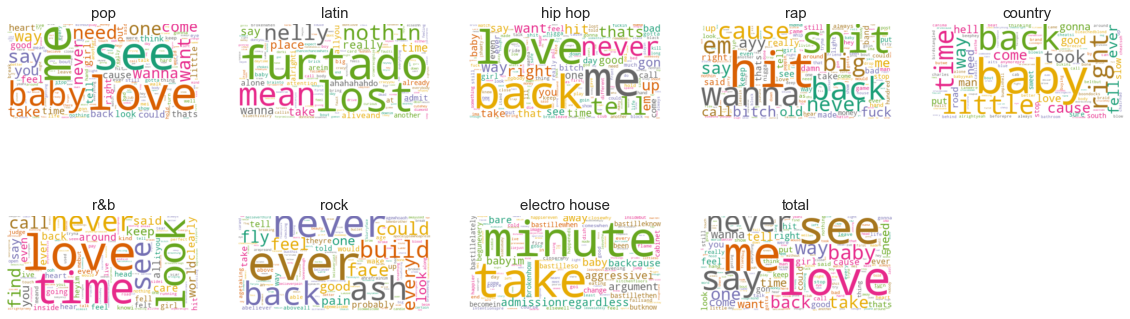

In [313]:
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
#Plot the word cloud
plot_wordcloud(gen_words,3,5)

In [44]:
df.to_csv("gernes_1.csv")